In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib widget
plt.rcParams.update({'figure.autolayout': True})

T1 = 0.00025 #0.035 m / 140 rad from TSA test
T2 = 5 #guess for leg movement/string contract

m_a = 1/2 * 0.020 * 0.010**2 #cylinder MOI 20g 10mm radius
m_l = 0.5 #mass to push off ground
k = 3000 # no idea honestly

tau_max = 0.05 #N*m stall torque
omega_max = 3000 #about 10,000rpm free speed

3.7489255131899557


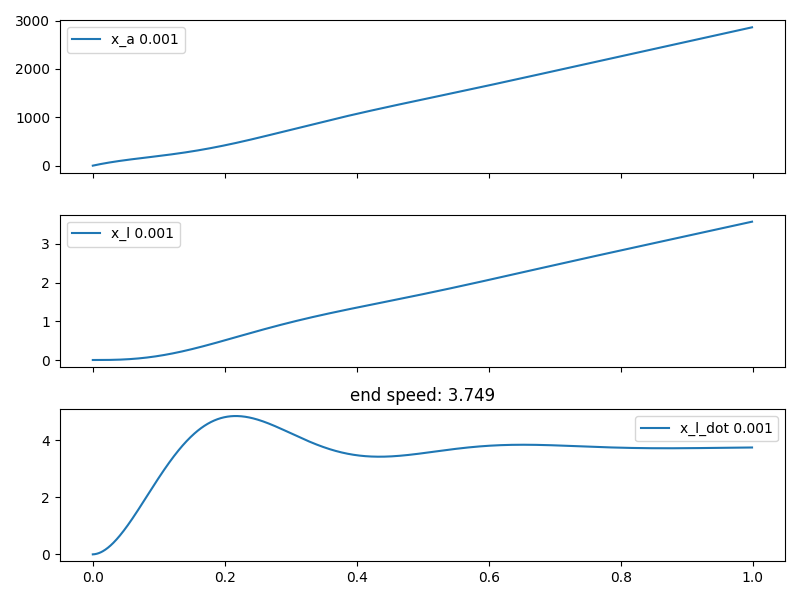

In [7]:
def f(X):
    c1 = -k * T1**2 * omega_max / tau_max
    c2 = k * T1 * omega_max / (tau_max * T2)
    c3 = k * T1 / (T2 * m_l)
    c4 = -k / (T2**2 * m_l)

    # Xdot = A*X where X = [x_a, x_l, x_l_dot]
    A = np.array([
        [c1, c2, 0],
        [0, 0, 1],
        [c3, c4, 0],
    ])
    b = [omega_max, 0, 0]

    X = np.array(X).reshape(3)
    return A@X + b

def RK4(f, X, dt):
    # Runge-Kutta 4 integration
    k1 = f(X)
    k2 = f(X + (dt/2)*k1)
    k3 = f(X + (dt/2)*k2)
    k4 = f(X + dt*k3)
    return X + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

X = np.array([0, 0, 0])
log = []
log_T = []

dt = 0.001
times = []
for ti in np.arange(0, 1, dt):
    X = RK4(f, X, dt)
    times.append(ti)
    log.append(X)
    log_T.append((T1, T2))

log = np.array(log)
log_T = np.array(log_T)
endv = log[:,2][-1]
print(endv)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8,6))
axs[0].plot(times, log[:,0], label=f'x_a {dt}')

# axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot {dt}')

axs[1].plot(times, log[:,1], label=f'x_l {dt}')

axs[2].plot(times, log[:,2], label=f'x_l_dot {dt}')
axs[2].set_title(f'end speed: {np.round(endv, 3)}')

# axs[3].plot(times, log_T[:,0], label=f'T1 {dt}')
# axs[4].plot(times, log_T[:,1], label=f'T2 {dt}')

for ax in axs:
    ax.legend()
plt.show()

In [6]:
from math import *

def get_state(t, ics=[0,0,0]):
    x_a0, x_l0, v_l0 = ics #inital conditions

    x0 = omega_max**2
    x1 = m_l*x0
    x2 = 1/tau_max
    x3 = T1**2
    x4 = T2**2
    x5 = x2*x3*x4
    x6 = T1*T2*omega_max
    x7 = m_l*v_l0*x6 + tau_max*x_a0
    x8 = (1/2)*v_l0 - 1/2*x6
    x9 = 1/T2
    x10 = sqrt(-T1**4*k**2*m_l**2*x0*x4 + 4*k*m_l*tau_max**2)
    x11 = (1/2)*x2
    x12 = t*x10*x11*x9/m_l
    x13 = exp(-k*omega_max*t*x11*x3)
    x14 = x13*cos(x12)
    x15 = x14*x8
    x16 = 2*x15
    x17 = T1**3*T2**3*x1
    x18 = 2*T1*T2*tau_max*x_a0 + m_l*omega_max*v_l0*x3*x4 - 2*tau_max*x_l0 - x17
    x19 = sin(x12)
    x20 = x13*x19/x10
    x21 = x18*x20
    x22 = k*m_l*omega_max
    x23 = x11*x18
    x_a_code = -T1*x2*x21*x22 - m_l*x16*x2*x6 + omega_max*t - x1*x5 + x2*x7
    x_l_code = T1*T2*omega_max*t + T1*T2*x2*x7 - T2*x20*x22*x23*x3 + T2*x10*x13*x19*x2*x8/k - m_l*omega_max*x15*x5 - x14*x23 - x17*x2
    v_l_code = k*x21*x9 + x16 + x6

    return [x_a_code, x_l_code, v_l_code]

times = []
log = []

dt = 0.1
times = []
for ti in np.arange(0, 0.5, dt):
    X = get_state(ti)
    times.append(ti)
    log.append(X)


log = np.array(log)

# fig, axs = plt.subplots(3, 1, sharex=0)
axs[0].plot(times, log[:,0], 'o', label='x_a ana')
axs[1].plot(times, log[:,1], 'o', label='x_l ana')
axs[2].plot(times, log[:,2], 'o', label='v_l ana')

for ax in axs:
    ax.legend()